Versions:
* v1: one full cycle. Not yet multiple cycles implemented

TODO inputdata: 
* FL not random generation
* distances based on OSRM route matrix

TODO model:
* Check values for disruption 1-2 of 0-1

<b> OSRM </b><br>
for installation:

pip install git+https://github.com/ustroetz/python-osrm

In [1]:
# Standard imports
import random
import pandas as pd
import numpy as np

# Own Model import
from lib.fl_model_v5 import *
# import lib.fl_model_v5 as flm

# for natural sorting
import re

#for nondominated sorting
import lib.pareto as pareto
from lib.list_imports import find_loaded_modules

# for parallel plotting
from lib.parallel_plotting import plot_optimal

# For checking ema running time
import time

In [2]:
import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [4]:
find_loaded_modules().HTML

Name,Version,Path,SHA
ema_workbench,1.1.3,,
git,2.1.9,,
json,2.0.9,,
lib.pareto,1.1.1-3,,
numpy,1.14.2,,
pandas,0.22.0,,
re,2.2.1,,


# FL Model test

Moved to different Notebook

# FL Model Nepal

## Nepal Data

In [5]:
Nepal = pd.read_csv("Data/Nepal Cities Population.csv", usecols=[1,2,3,4])

# Take only larger cities, because of many null values under 50000 inhabitants. 
# TODO find better dataset with population and coordinates
Nepal = Nepal [Nepal.Population >= 50000]
Nepal.head(1)

,City,Population,Latitude (DD),Longitude (DD)
0,Kathmandu,743300,27.71,85.31


In [6]:
airports = pd.read_csv("Data/Nepal Airports.csv", usecols=[0,5,6])
int_airports = airports[airports['Airport'] == "Tribhuvan intl"]
int_airports.head()

,Airport,Latitude (DD),Longitude (DD)
7,Tribhuvan intl,27.7,85.36


### Unfinished: Get Nepal Facility Location nodes -  Do: GIS analysis

### Format DPs, SPs random Data FLS, 

In [7]:
DPs = Nepal
# np.random.seed(0)
# DPs['Demand_estimate'] = np.random.randint(0, 100, DPs.shape[0]) * DPs['Population']  # change random for impact factor
# DPs['Demand_lower'] = DPs['Demand_estimate'] * 0.9
# DPs['Demand_upper'] = DPs['Demand_estimate'] * 1.1
# DPs['Demand_actual'] = np.random.uniform(DPs['Demand_lower'],DPs['Demand_upper'])
# DPs['Demand_actual'] = DPs['Demand_actual'].apply(int)
# DPs.head()

In [8]:
SPs = int_airports.reset_index(drop=True)
SPs

,Airport,Latitude (DD),Longitude (DD)
0,Tribhuvan intl,27.7,85.36


In [9]:
long = np.random.uniform(DPs['Longitude (DD)'].min(),
                         DPs['Longitude (DD)'].max(), 20)
lat = np.random.uniform(DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max(),
                        20)
FLs = pd.DataFrame([lat, long], index=['Lat', 'Lon']).T
FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]
FLs = FLs[['Name', 'Lat', 'Lon']]
FLs.head()

,Name,Lat,Lon
0,FLO0,27.222042,81.742715
1,FLO1,27.363120,84.641882
2,FLO2,28.763975,81.974667
3,FLO3,26.687969,86.698107
4,FLO4,27.058977,81.867943


## Nepal Instantiation 

In [206]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(Nepal['Latitude (DD)'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(Nepal['Longitude (DD)'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(int_airports['Latitude (DD)'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(int_airports['Longitude (DD)'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(Nepal['Population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}



# DSR = Disruption
DSRDP = {"DSRDP{}".format(i): random.uniform (1, 2) for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): random.uniform (1, 2) for i in range(len(FLX))}

# Decision Variables
start_situation = {key:0 for key in FLs.Name}

In [207]:
# fixed_certain_data = merge_dicts(**DPY, **DPX, **SPY, **SPX, **FLX, **FLY,
#                                  **DPpop)

# df_fixed_certain_data = pd.DataFrame.from_dict(
#     fixed_certain_data, orient="index")

# fixed_uncertain_data = "TODO"

In [208]:
# def merge_dicts(**kwargs):
#     return kwargs

In [243]:
var_unc_data = []

t = 0
# t += 1

var_unc_data.append({**DSRDP, **DSRFL})
if len(var_unc_data) != t+1:
    raise ValueError(
        "TTR: The time period is not equal to the amount of elements there are in the variable uncertantie data list"
    )

In [244]:
list_df_var_unc_data = []
list_df_var_unc_data.append(pd.DataFrame.from_dict(var_unc_data[0], orient='index'))

In [245]:
t=0

In [246]:
# create upper and lower bound
list_df_var_unc_data[t] = list_df_var_unc_data[t].rename(columns={0:"actual"})
list_df_var_unc_data[t]['lower']= (list_df_var_unc_data[t]['actual'] - 1) * np.random.uniform(size=list_df_var_unc_data[t].shape[0]) + 1
list_df_var_unc_data[t]['upper']= (2 - list_df_var_unc_data[t]['actual']) * np.random.uniform(size=list_df_var_unc_data[t].shape[0]) + list_df_var_unc_data[t]['actual'] 
list_df_var_unc_data[t]['best_estimate'] = (list_df_var_unc_data[t]['upper'] + list_df_var_unc_data[t]['lower']) / 2
list_df_var_unc_data[t]['difference'] = list_df_var_unc_data[t]['best_estimate'] - list_df_var_unc_data[t]['actual']
list_df_var_unc_data[t].head(1)

,actual,lower,upper,best_estimate,difference
DSRDP0,1.02253,1.005736,1.953625,1.47968,0.45715


In [253]:
best_estimate_disruptions = {i:be for be,i in zip(list_df_var_unc_data[t]['best_estimate'] ,list_df_var_unc_data[t].index) }

## Nepal Model Evaluator

Testing

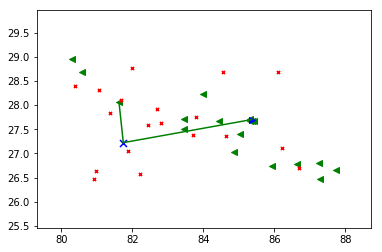

(11.0, 17, 3495985.2404074194, 27.617454807575655, 1)

In [255]:
start_situation['FLO0'] = 1
FL_model(
    unit_opening_costs = 1,
    unit_transport_cost= 0,
    FL_operations_cost = 10,
    graphical_representation = True,
    FL_range=100, # km? --> meters
    dist_method="great_circle",
    lorry_speed=20, #km/h? -->m/s
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **start_situation,
    **best_estimate_disruptions,
    **DPpop)


# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

In [256]:
start_situation = {key:0 for key in FLs.Name}
current_situation = start_situation

In [257]:
def create_policies(FL_dict, print_pols=False):
    """
    Takes the current network of Facility Locations and returns all possible policies for one added FL.
    
    Input: current option (Dict of FLs)
    Output: List of options (Dicts of FLs)
    
    Printing module not completely reliable. doesnt print whats actually in thereTODO
    """
    def natural_key(string_):
        return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]
    
    # All FL names
    FL_keys = sorted(FL_dict.keys(),key=natural_key)
    # All FL values indicating whether operational
    FL_values = [FL_dict[key] for key in FL_keys]
    
    i_operational_fls = i_FL_op = [i for i,x in enumerate(FL_values) if x == 1]
    
    # Create list of policies  
    pols = np.identity(len(FL_keys))
    # Set already operational facilities to operational
    pols[:,i_operational_fls] = 1
    
    #Delete policies where no new FLs are placed 
    new_n_operational_fls = sum(FL_values) + 1
    pols = pols[pols.sum(axis = 1) == new_n_operational_fls]

    
    # Return a list of dictionaries
    policy_list = []
    for pol in pols:
        policy_list.append({key:value for key,value in zip(FL_keys,pol)})
    
    if print_pols == True:
        print("total policies:",len(policy_list))
        for n,i in enumerate(policy_list):
            for v in i.values():
                print (int(v), end='')
            print(" <- policy {}".format(n))
                
    return policy_list

In [258]:
optional_policies = create_policies(current_situation, print_pols=False)

In [259]:
# %%timeit
# Evaluate all optional policies with best estimate values
best_est_results_opt_pols = []
for policy in optional_policies:
    best_est_results_opt_pols.append(
        FL_model(
            unit_opening_costs=100,
            unit_transport_cost=1,
            FL_operations_cost = 10,
            graphical_representation=False,
            FL_range=50, # km? --> m
            dist_method="great_circle",
            lorry_speed=60, #km/u? --> m/s
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **best_estimate_disruptions,
            **DPpop))

In [260]:
len(optional_policies)

20

In [261]:
# outcome indicators, as internally used by the model
oois = ['total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand','max_distr_time']
# Put outcomes in DF

df_best_est_results_opt_pols = pd.DataFrame(np.asarray(best_est_results_opt_pols)[:,:4],columns=oois)
df_best_est_results_opt_pols.head()

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
0,1.100000e+02,18.0,3.579708e+06,0.000000
1,9.676888e+07,15.0,3.119638e+06,3.712077
2,1.100000e+02,18.0,3.579708e+06,0.000000
3,2.945150e+07,17.0,3.473751e+06,4.632597
4,1.100000e+02,18.0,3.579708e+06,0.000000


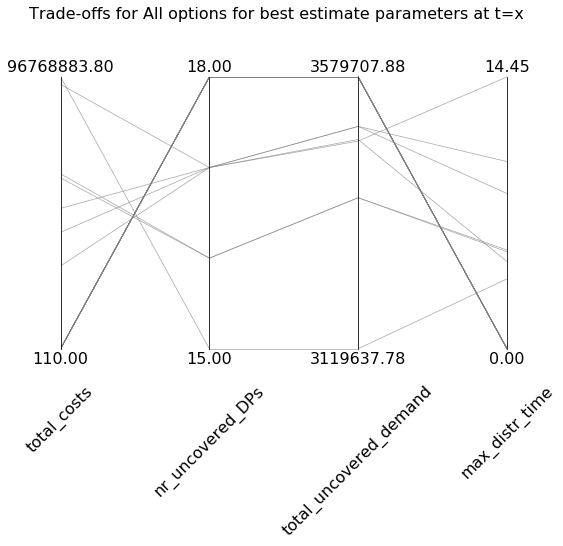

In [262]:
title = "Trade-offs for All options for best estimate parameters at t=x"
plot_optimal(df_best_est_results_opt_pols, oois, title)

In [263]:
# options for pareto sorting# minimising is default
kwargs = {"maximize_all": True}
kwargs2 = {"maximize": [0, 1]}

nondominated_BE_policy_results = np.array(pareto.eps_sort(
    [list(df_best_est_results_opt_pols.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

#Filter out those where new demand is covered
nondominated_BE_policy_results = nondominated_BE_policy_results[nondominated_BE_policy_results[:,4] != 0]

# Put outcomes in DF
df_nondominated_BE_policy_results = pd.DataFrame(
    np.asarray(nondominated_BE_policy_results),
    columns=["pol_i"] + oois).set_index("pol_i")
df_nondominated_BE_policy_results

,total_costs,nr_uncovered_DPs,total_uncovered_demand,max_distr_time
pol_i,,,,
1.0,9.676888e+07,15.0,3.119638e+06,3.712077
3.0,2.945150e+07,17.0,3.473751e+06,4.632597
11.0,6.228178e+07,16.0,3.375308e+06,5.158525
18.0,6.085287e+07,16.0,3.375308e+06,5.247067


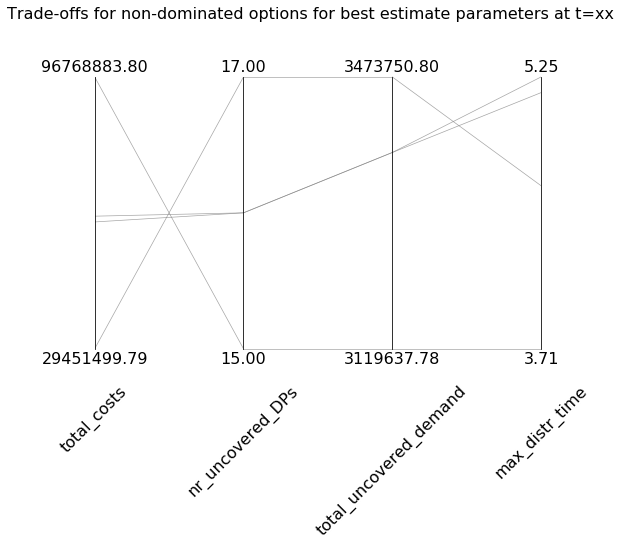

In [264]:
title = "Trade-offs for non-dominated options for best estimate parameters at t=xx"
plot_optimal(df_nondominated_BE_policy_results, oois, title)

In [265]:
# policies for all nondominated policies
nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]

nondominated_BE_policies = np.array(optional_policies)[nondom_i]
nondominated_BE_policies

array([{'FLO0': 0.0, 'FLO1': 1.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 1.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 1.0, 'FLO12': 0.0, 'FLO13': 0.0, 'FLO14': 0.0, 'FLO15': 0.0, 'FLO16': 0.0, 'FLO17': 0.0, 'FLO18': 0.0, 'FLO19': 0.0},
       {'FLO0': 0.0, 'FLO1': 0.0, 'FLO2': 0.0, 'FLO3': 0.0, 'FLO4': 0.0, 'FLO5': 0.0, 'FLO6': 0.0, 'FLO7': 0.0, 'FLO8': 0.0, 'FLO9': 0.0, 'FLO10': 0.0, 'FLO11': 0.

#### visualise all nondom pols

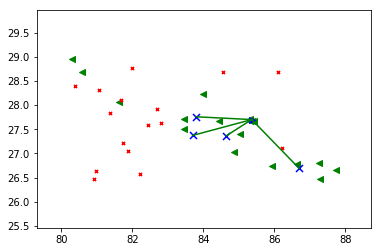

These are all the FLs that are in the set of non-dominated policies


In [267]:
# inspect nondominated results

all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}

FL_model(
    unit_opening_costs=0,
    unit_transport_cost=0,
    FL_operations_cost = 0,
    graphical_representation=True,
    FL_range=0, # km? --> m
    dist_method="great_circle",
    lorry_speed=1, #km/u? --> m/s
    **SPX,
    **SPY,
    **DPX,
    **DPY,
    **FLX,
    **FLY,
    **all_nondom_BE_pols,
    **best_estimate_disruptions,
    **DPpop)
print("These are all the FLs that are in the set of non-dominated policies")

# EMA Framework

## EMA instantiations

In [268]:
t

0

In [269]:
models = []
model = Model("flmodelt{}".format(t), FL_model)

model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['Longitude (DD)'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['Latitude (DD)'])
] + [
    Constant("SPX{}".format(i), x)
    for i, x in zip(SPs.index, SPs['Longitude (DD)'])
] + [
    Constant("SPY{}".format(i), y)
    for i, y in zip(SPs.index, SPs['Latitude (DD)'])
] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
    Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
]

# model.locations_uncertain =   [
#     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
# ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

model.constants = [
    Constant('graphical_representation', False),
    Constant('dist_method', 'great_circle'),
    Constant('Error_Test', 1),  # this doesn't do anything. 
    #list of other constants
    #     Constant
] + model.locations + [  # population DPs
    Constant("DPpop{}".format(i), pop)
    for i, pop in zip(Nepal.index, Nepal['Population'])
]

# Reachability of Demand Points and Facility Locations can be disrupted
# Disruption also determines demand (disr-1)*pop
model.disruptions = [
    RealParameter(i, l, u)
    for i, l, u in zip(list_df_var_unc_data[t].index, list_df_var_unc_data[t][
        'lower'], list_df_var_unc_data[t]['upper'])
]

model.uncertainties = [
    RealParameter('unit_opening_costs', 100, 200),
    RealParameter('unit_transport_cost', 0.5,
                  2),  # cost of transporting one unit of relief goods
    RealParameter('FL_operations_cost', 20, 50),
    RealParameter('FL_range', 100, 300),  # km TODO: great circle distance
    RealParameter(
        'lorry_speed', 30, 60
    ),  # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
    #list of other uncertainties
] + model.disruptions  #+ model.locations_uncertain

model.outcomes = [
    ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome(
        "max_distr_time",
        kind=ScalarOutcome.MINIMIZE,
    )
]

models.append(model)

In [50]:
# models = []
# t = 0
# model = Model("flmodelt{}".format(t), FL_model)

# model.locations = [
#     Constant("DPX{}".format(i), x)
#     for i, x in zip(DPs.index, DPs['Longitude (DD)'])
# ] + [
#     Constant("DPY{}".format(i), y)
#     for i, y in zip(DPs.index, DPs['Latitude (DD)'])
# ] + [
#     Constant("SPX{}".format(i), x)
#     for i, x in zip(SPs.index, SPs['Longitude (DD)'])
# ] + [
#     Constant("SPY{}".format(i), y)
#     for i, y in zip(SPs.index, SPs['Latitude (DD)'])
# ] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
#     Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
# ]

# # model.locations_uncertain =   [
# #     RealParameter("FLX{}".format(i), DPs['Longitude (DD)'].min(), DPs['Longitude (DD)'].max()) for i in range(nr_of_FLs)
# # ] + [RealParameter("FLY{}".format(i), DPs['Latitude (DD)'].min(), DPs['Latitude (DD)'].max()) for i in range(nr_of_FLs)]

# model.constants = [
#     Constant('graphical_representation', False),
#     Constant('dist_method', 'great_circle'),
#     Constant('Error_Test', 1),  # this doesn't do anything. 
#     #list of other constants
#     #     Constant
# ] + model.locations + [  # population DPs
#     Constant("DPpop{}".format(i), pop)
#     for i, pop in zip(Nepal.index, Nepal['Population'])
# ]

# # Reachability of Demand Points and Facility Locations can be disrupted
# # Disruption also determines demand (disr-1)*pop
# model.disruptions = [
#     RealParameter("DSRFL{}".format(i), 1, 2) for i in range(FLs.shape[0])
# ] + [RealParameter("DSRDP{}".format(i), 1, 2) for i in range(DPs.shape[0])]

# model.uncertainties = [
#     RealParameter('unit_opening_costs', 100, 200),
#     RealParameter('unit_transport_cost', 0.5,
#                   2),  # cost of transporting one unit of relief goods
#     RealParameter('FL_operations_cost', 20, 50),
#     RealParameter('FL_range', 100, 300),  # km TODO: great circle distance
#     RealParameter(
#         'lorry_speed', 30, 60
#     ),  # km/h. Speed is Average speed. Constant, because roads are individually disrupted 
#     #list of other uncertainties
# ] + model.disruptions  #+ model.locations_uncertain

# model.outcomes = [
#     ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
#     ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
#     ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
#     ScalarOutcome(
#         "max_distr_time",
#         kind=ScalarOutcome.MINIMIZE,
#     )
# ]

# models.append(model)

In [270]:
if [o.name for o in models[0].outcomes] != oois:
    print("Watch out! Oois and model outcome names are not similar!")

In [271]:
for model in models:
    print(model.name)

flmodelt0


In [272]:
nondominated_BE_policies_EMA = []
for name, pol in zip(nondom_i,nondominated_BE_policies):
    nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

In [274]:
time1 = time.time()
n_scen = 100
all_scen_results_nondom_pols = perform_experiments(
    model, n_scen, nondominated_BE_policies_EMA)
time2 = time.time()
print("Total time:{}".format(time2 - time1), "\n", "time per run = {}".format(
    (time2 - time1) / (n_scen * len(nondominated_BE_policies_EMA))))

[MainProcess/INFO] performing 100 scenarios * 4 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished


Total time:20.35847020149231 
 time per run = 0.050896175503730774


timelog: (3000 experiments)
1. possibly with cpu problems due to failed multiprocessing <br>
Total time:186.64591431617737 <br>
time per run = 0.18664591431617736
2. model v2 <br>
Total time:156.22968077659607  <br>
 time per run = 0.15622968077659607
3. model v2 4 policies <br>
Total time:200.71212720870972 
 time per run = 0.2007121272087097
4. 
Total time:144.36057209968567 <br>
 time per run = 0.14436057209968567
 
5. 
Total time:69.68182039260864 <br>
 time per run = 0.06968182039260865
 
6. Probably had wrong parameters for timer <br>
now: 0.05089 per run 400 experiments

In [277]:
# Add parameter in filename for period t=1,2...x
ema.save_results(all_scen_results_nondom_pols, "results/candidate_policy_robustness_v3_t{}.tar.gz".format(t))

[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\candidate_policy_robustness_v3_t0.tar.gz


# Robustness Framework

In [278]:
all_scen_results_nondom_pols = ema.load_results("results/candidate_policy_robustness_v3_t{}.tar.gz".format(t))
experiments, outcomes = all_scen_results_nondom_pols

[MainProcess/INFO] results loaded succesfully from C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\results\candidate_policy_robustness_v3_t0.tar.gz


In [279]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

sigN_results = []

for policy in nondominated_BE_policies_EMA:
    #filter the outcome values corresponding to each policy using a logical index
    logical_index = experiments['policy']==int(policy.name)
    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}
    temp_result = {}
    for ooi in models[0].outcomes:
        temp_result[ooi.name] = calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind)
    sigN_results.append(temp_result)    


In [280]:
df_sigN = pd.DataFrame(sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])
df_sigN

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
1,45.961573,21.146212,3.410506e+17,2.308107e+11
3,57.854643,40.655251,8.852514e+17,1.560039e+12
11,53.131671,38.923341,8.798284e+17,1.322342e+12
18,50.741556,36.887494,7.429980e+17,1.161805e+12


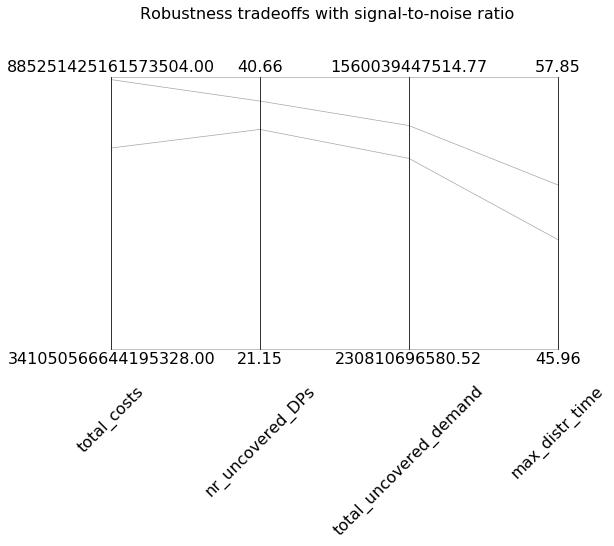

In [281]:

title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sigN, oois, title)

In [282]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

In [283]:
reg_results = {}
# we need to iterate over the outcomes differently now, 
#because the maximum egret calculation requires the outcome values for all policies
for ooi in models[0].outcomes:
    data = []
    for policy in nondominated_BE_policies_EMA:
        logical_index = experiments['policy'] == int(policy.name) 
        data.append(outcomes[ooi.name][logical_index])
    reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    


In [284]:
reg_results

{'total_costs': array([9.55846078e+08, 1.42633011e+09, 1.45678709e+09, 1.56588158e+09]),
 'nr_uncovered_DPs': array([0., 6., 5., 6.]),
 'total_uncovered_demand': array([  42566.77574419, 2330018.87836865, 2035168.9682527 ,
        1968531.17485577]),
 'max_distr_time': array([4.68669547, 8.26133371, 7.12771301, 6.45512867])}

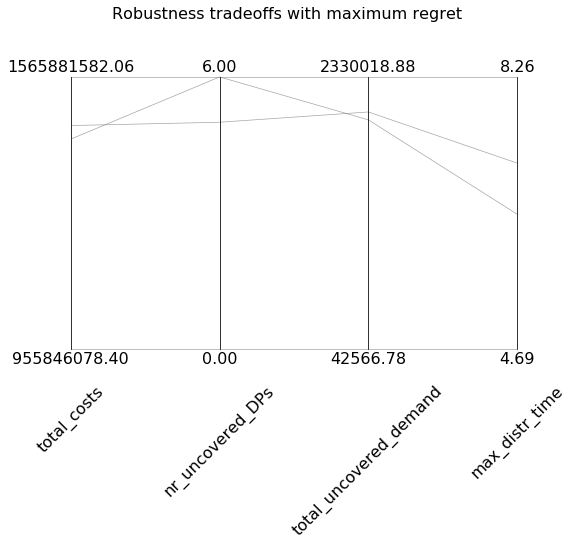

In [285]:
# we can again convert the robustness values into a dataframe. 
#However, since the results are in a dictionary, we need to do it differently.
df_regret = pd.DataFrame.from_dict(reg_results, orient='columns',)
df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]
title = "Robustness tradeoffs with maximum regret"
plot_optimal(df_regret, oois, title)

## Choose nondominated robust policies

In [286]:
df_regret

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
1,4.686695,0.0,9.558461e+08,4.256678e+04
3,8.261334,6.0,1.426330e+09,2.330019e+06
11,7.127713,5.0,1.456787e+09,2.035169e+06
18,6.455129,6.0,1.565882e+09,1.968531e+06


In [287]:
df_sigN

,max_distr_time,nr_uncovered_DPs,total_costs,total_uncovered_demand
1,45.961573,21.146212,3.410506e+17,2.308107e+11
3,57.854643,40.655251,8.852514e+17,1.560039e+12
11,53.131671,38.923341,8.798284e+17,1.322342e+12
18,50.741556,36.887494,7.429980e+17,1.161805e+12


In [288]:
all_robustness_scores = pd.merge(df_regret,df_sigN, left_index=True, right_index=True)

In [289]:
all_robustness_scores

,max_distr_time_x,nr_uncovered_DPs_x,total_costs_x,total_uncovered_demand_x,max_distr_time_y,nr_uncovered_DPs_y,total_costs_y,total_uncovered_demand_y
1,4.686695,0.0,9.558461e+08,4.256678e+04,45.961573,21.146212,3.410506e+17,2.308107e+11
3,8.261334,6.0,1.426330e+09,2.330019e+06,57.854643,40.655251,8.852514e+17,1.560039e+12
11,7.127713,5.0,1.456787e+09,2.035169e+06,53.131671,38.923341,8.798284e+17,1.322342e+12
18,6.455129,6.0,1.565882e+09,1.968531e+06,50.741556,36.887494,7.429980e+17,1.161805e+12


Use small epsilon value, because efficiency is not relevant (because of low numbers of alternatives, smaller epsilon is possible. larger epsilon leads to faster processing time)

In [290]:
# Non-dominated sorting for outcomes


# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

robust_nondominated_policies = pareto.eps_sort([list(all_robustness_scores.itertuples(index=True))],[i+1 for i in range(all_robustness_scores.shape[1])], [1e-9] * all_robustness_scores.shape[1])
robust_nondominated_policies

[['1',
  4.686695470840764,
  0.0,
  955846078.4040086,
  42566.77574418858,
  45.96157253535745,
  21.146212082710647,
  3.410505666441953e+17,
  230810696580.52405]]

In [296]:
if len(robust_nondominated_policies) ==0:
    print("something went wrong")
elif len(robust_nondominated_policies) == 1:
    temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

    df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")
#     print(robust_nondominated_policies)
    df_temp
else:
    temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

    df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    plot_optimal(df_temp, all_robustness_scores.columns, "robust nondominated policies")

In [298]:
df_temp

,max_distr_time_x,nr_uncovered_DPs_x,total_costs_x,total_uncovered_demand_x,max_distr_time_y,nr_uncovered_DPs_y,total_costs_y,total_uncovered_demand_y
pol_i,,,,,,,,
1,4.686695,0.0,9.558461e+08,42566.775744,45.961573,21.146212,3.410506e+17,2.308107e+11


# Next iteration Framework

Pseudocode:

minimodel:
    
    for each info item:
        how close to closest operational fl?
        allocated to closest operational fl?
        
        reduce uncertainty range: delta: (upper-lower)